In [1]:
import numpy as np
import cv2
import matplotlib
from matplotlib import pyplot as plt
%matplotlib inline

In [2]:
img = cv2.imread("test1.jpg")
img.shape

(1200, 1200, 3)

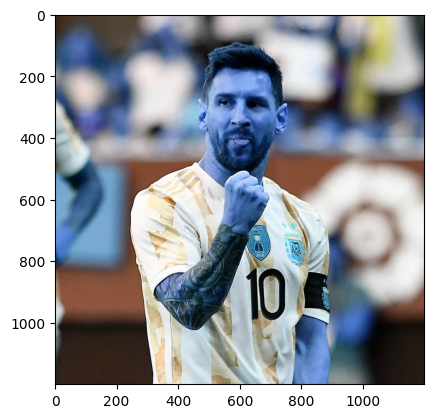

In [3]:
plt.imshow(img)

In [4]:
gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
gray.shape

(1200, 1200)

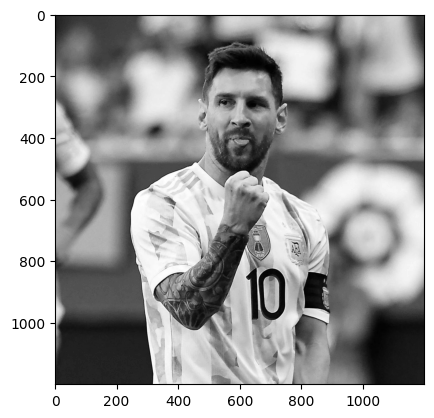

In [6]:
plt.imshow(gray, cmap='gray')

In [25]:
face_cascade = cv2.CascadeClassifier('../../opencv/haarcascades/haarcascade_frontalface_default.xml')
eye_cascade = cv2.CascadeClassifier('../../opencv/haarcascades/haarcascade_eye.xml')
faces = face_cascade.detectMultiScale(gray, 1.3, 5)
faces

array([[ 49, 197,  80,  80],
       [462, 179, 283, 283]])

In [19]:
x,y,w,h = faces[1]
x, y, w, h

(462, 179, 283, 283)

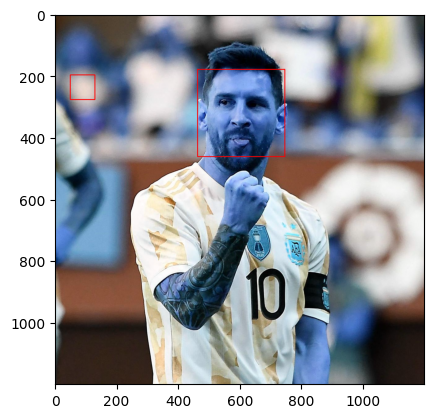

In [21]:
face_img = cv2.rectangle(img, (x,y), (x+w, y+h), (255,0,0), 2)
plt.imshow(face_img)

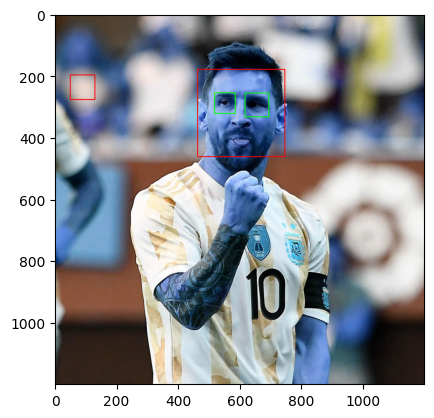

In [22]:
for (x,y,w,h) in faces:
    img = cv2.rectangle(img,(x,y),(x+w,y+h),(255,0,0),2)
    roi_gray = gray[y:y+h, x:x+w]
    roi_color = img[y:y+h, x:x+w]
    eyes = eye_cascade.detectMultiScale(roi_gray)
    for (ex,ey,ew,eh) in eyes:
        cv2.rectangle(roi_color,(ex,ey),(ex+ew,ey+eh),(0,255,0),2)
plt.figure()
plt.imshow(face_img, cmap='gray')
plt.show()

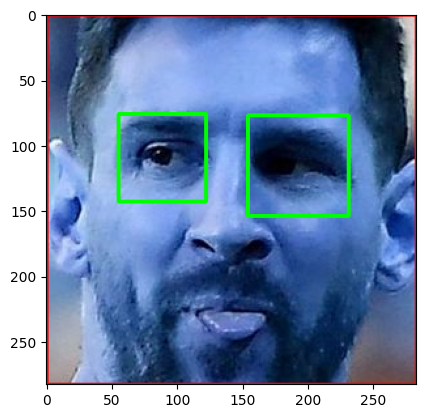

In [23]:
%matplotlib inline
plt.imshow(roi_color, cmap='gray')

In [92]:
def get_cropped_image(img_path):
    img = cv2.imread(img_path)
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    faces = face_cascade.detectMultiScale(gray, 1.3, 5)
    for x,y,w,h in faces:
        roi_gray = gray[y:y+h, x:x+w]
        roi_color = img[y:y+h, x:x+w]
        eyes = eye_cascade.detectMultiScale(roi_gray)
        if len(eyes) >=2:
            return roi_color

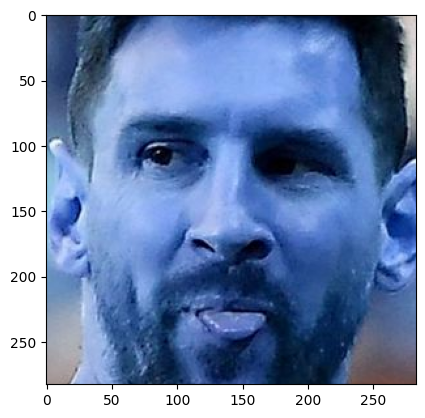

In [56]:
cropped_image = get_cropped_image('test1.jpg')
plt.imshow(cropped_image)

In [57]:
path_to_cropped_data = "../celebs/cropped/"
path_to_data = "../celebs/"
import os
img_dirs = []
for entry in os.scandir(path_to_data):
    if entry.is_dir():
        img_dirs.append(entry.path)
img_dirs

['../celebs/mbappe', '../celebs/messi', '../celebs/ronaldo']

In [60]:
import shutil
if os.path.exists(path_to_cropped_data):
    shutil.rmtree(path_to_cropped_data)    # removes the folder if it exists
os.mkdir(path_to_cropped_data)

In [2]:
cropped_image_dirs = []
celeb_dict = {}
for img_dir in img_dirs:
    count = 1
    celebrity = img_dir.split('/')[-1]
    celeb_dict[celebrity] = []
    dirs = os.listdir(img_dir)
    for entry in dirs:
        path = img_dir + '/'+ entry
        if '._' in entry:
            continue
        roi_color = get_cropped_image(path)
        if roi_color is not None:
            cropped_folder = path_to_cropped_data + celebrity
            if not os.path.exists(cropped_folder):
                os.makedirs(cropped_folder)
                cropped_image_dirs.append(cropped_folder)
                print("Generating cropped images in folder: ", cropped_folder)
            cropped_file_name = celebrity + str(count) + ".png"
            cropped_file_path = cropped_folder + "/" + cropped_file_name
            
            cv2.imwrite(cropped_file_path, roi_color)
            celeb_dict[celebrity].append(cropped_file_path)
            count += 1


NameError: name 'img_dirs' is not defined

In [99]:
import numpy as np
import pywt
import cv2

def w2d(img, mode='haar', level=1):
    imArray=img
    imArray = cv2.cvtColor(imArray, cv2.COLOR_RGB2GRAY)
    imArray = np.float32(imArray)
    imArray /= 255;
    coeffs = pywt.wavedec2(imArray, mode, level=level)
    
    coeffs_H = list(coeffs)
    coeffs_H[0] *= 0;
    
    imArray_H = pywt.waverec2(coeffs_H, mode);
    imArray_H *=255;
    imArray_H = np.uint8(imArray_H)
    
    return imArray_H

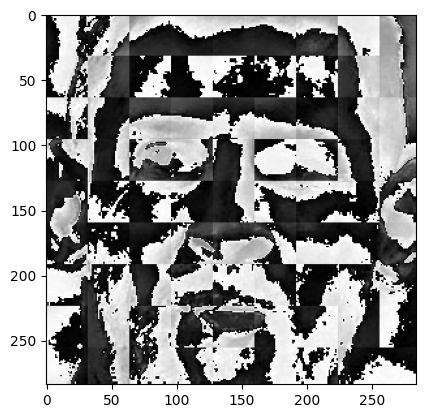

In [100]:
im_har = w2d(cropped_image, 'db1', 5)
plt.imshow(im_har, cmap='gray')

In [101]:
class_dict = {}
count = 0
for celebrity_name in celeb_dict.keys():
    class_dict[celebrity_name] = count
    count += 1
class_dict

{'mbappe': 0, 'messi': 1, 'ronaldo': 2}

In [1]:
X, y = [], []
for celebrity_name, training_files in celeb_dict.items():
    for training_image in training_files:
        img = cv2.imread(training_image)
        if img is None:
            continue
        scalled_raw_img = cv2.resize(img, (32, 32))
        img_har = w2d(img, 'db1', 5)
        scalled_img_har = cv2.resize(img_har, (32, 32))
        combined_img = np.vstack((scalled_raw_img.reshape(32*32*3, 1), scalled_img_har.reshape(32*32, 1)))
        X.append(combined_img)
        y.append(class_dict[celebrity_name])

NameError: name 'celeb_dict' is not defined

In [127]:
X = np.array(X).reshape(len(X),4096).astype(float)
X.shape

(147, 4096)

In [130]:
from sklearn.svm import SVC
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.metrics import classification_report

In [131]:
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=0)

pipe = Pipeline([('scaler', StandardScaler()), ('svc', SVC(kernel = 'rbf', C = 10))])
pipe.fit(X_train, y_train)
pipe.score(X_test, y_test)

0.7297297297297297

In [133]:
print(classification_report(y_test, pipe.predict(X_test)))

              precision    recall  f1-score   support

           0       0.90      0.64      0.75        14
           1       0.78      0.78      0.78         9
           2       0.61      0.79      0.69        14

    accuracy                           0.73        37
   macro avg       0.76      0.74      0.74        37
weighted avg       0.76      0.73      0.73        37



In [136]:
from sklearn import svm
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import make_pipeline
from sklearn.model_selection import GridSearchCV
model_params = {
    'svm': {
        'model': svm.SVC(gamma='auto',probability=True),
        'params' : {
            'svc__C': [1,10,100,1000],
            'svc__kernel': ['rbf','linear']
        }  
    },
    'random_forest': {
        'model': RandomForestClassifier(),
        'params' : {
            'randomforestclassifier__n_estimators': [1,5,10]
        }
    },
    'logistic_regression' : {
        'model': LogisticRegression(solver='liblinear',multi_class='auto'),
        'params': {
            'logisticregression__C': [1,5,10]
        }
    }
}

In [140]:
scores = []
best_estimators = {}
import pandas as pd
for algo, mp in model_params.items():
    pipe = make_pipeline(StandardScaler(), mp['model'])
    clf =  GridSearchCV(pipe, mp['params'], cv=5, return_train_score=False)
    clf.fit(X_train, y_train)
    scores.append({
        'model': algo,
        'best_score': clf.best_score_,
        'best_params': clf.best_params_
    })
    best_estimators[algo] = clf.best_estimator_
    
df = pd.DataFrame(scores,columns=['model','best_score','best_params'])
best_estimators

{'svm': Pipeline(steps=[('standardscaler', StandardScaler()),
                 ('svc',
                  SVC(C=1, gamma='auto', kernel='linear', probability=True))]),
 'random_forest': Pipeline(steps=[('standardscaler', StandardScaler()),
                 ('randomforestclassifier',
                  RandomForestClassifier(n_estimators=5))]),
 'logistic_regression': Pipeline(steps=[('standardscaler', StandardScaler()),
                 ('logisticregression',
                  LogisticRegression(C=1, solver='liblinear'))])}

In [142]:
best_clf = best_estimators['svm']
best_clf

Pipeline(steps=[('standardscaler', StandardScaler()),
                ('svc',
                 SVC(C=1, gamma='auto', kernel='linear', probability=True))])

Text(95.72222222222221, 0.5, 'Truth')

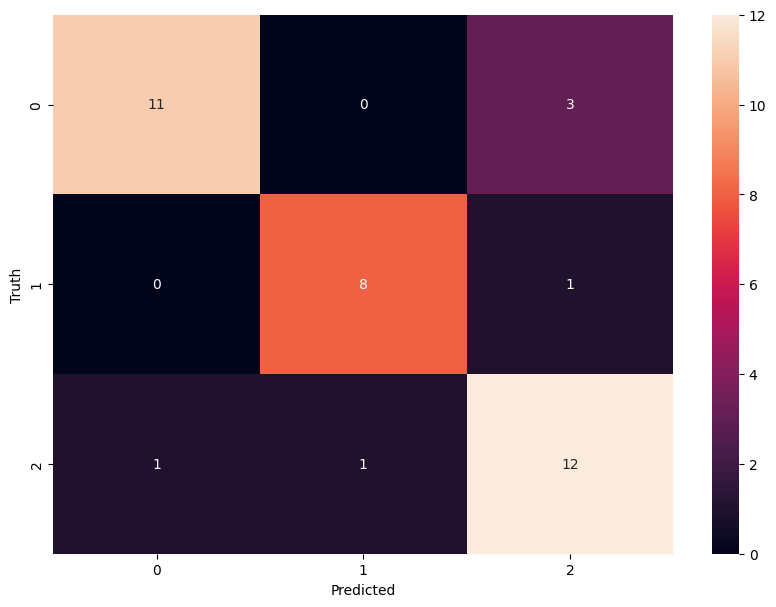

In [144]:
import seaborn as sn
from sklearn.metrics import confusion_matrix
cm = confusion_matrix(y_test, best_clf.predict(X_test))
plt.figure(figsize = (10,7))
sn.heatmap(cm, annot=True)
plt.xlabel('Predicted')
plt.ylabel('Truth')

In [145]:
import joblib 
joblib.dump(best_clf, 'saved_model.pkl')  # Save the model as a pickle in a file

['saved_model.pkl']

In [146]:
import json
with open("class_dictionary.json","w") as f:
    f.write(json.dumps(class_dict))